In [1]:
# import libraries

import ROOT
import numpy as np
from IPython.display import Image
from subprocess import call

import hax
hax.init(main_data_paths=['/project/lgrandi/xenon100/archive/root/merged/xenon100/run_14_pax4.1.2/'],
         raw_data_local_path='/project/lgrandi/tunnell/')

from Kr83m_Basic import *

#hax.ipython.code_hider()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# datasets processed by pax_4.1.2
datasets = ['xe100_150413_1839','xe100_150414_1535',
               'xe100_150419_1611','xe100_150420_0304',
               'xe100_150420_1809']

# pax path
paxPath = '/project/lgrandi/xenon100/archive/root/merged/xenon100/run_14_pax4.1.2/'

In [3]:
# load minitrees
# throws error when building minitrees for many datasets, I built them one by one

data = hax.minitrees.load(datasets, treemakers=Kr83m_Basic)
data = data[data['s10Time']>=0]

Found minitree at ./xe100_150413_1839_Kr83m_Basic.root
Found minitree at ./xe100_150414_1535_Kr83m_Basic.root
Found minitree at ./xe100_150419_1611_Kr83m_Basic.root
Found minitree at ./xe100_150420_0304_Kr83m_Basic.root
Found minitree at ./xe100_150420_1809_Kr83m_Basic.root


In [4]:
# Position Histograms

xyH = ROOT.TH2D('','',100,-16,16,100,-16,16)
rrzH = ROOT.TH2D('','',100,0,256,100,0,34)
for i in range(len(data)):
    xyH.Fill(data['s10x'].values[i],data['s10y'].values[i])
    rrzH.Fill(data['s10x'].values[i]**2+data['s10y'].values[i]**2,data['s10z'].values[i])

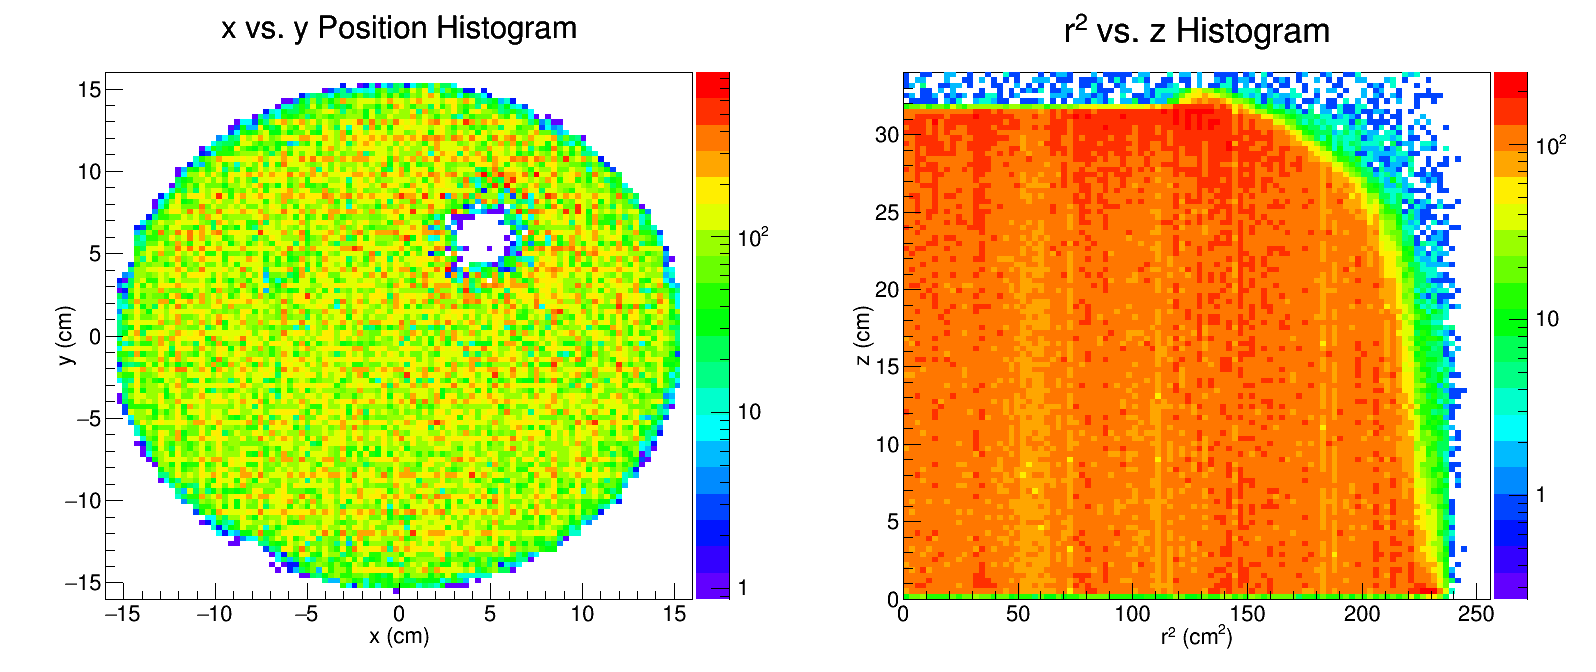

In [5]:
# Position Plots

c1 = ROOT.TCanvas('','', 1600, 700 )
c1.Divide(2,1,0.02,0.01)
ROOT.gStyle.SetOptStat(0)

p1a = c1.cd(1)
p1a.SetLogz()
xyH.SetTitle('x vs. y Position Histogram')
xyH.GetXaxis().SetTitle('x (cm)')
xyH.GetXaxis().CenterTitle()
xyH.GetYaxis().SetTitle('y (cm)')
xyH.GetYaxis().CenterTitle()
xyH.Draw('colz')

p1b = c1.cd(2)
p1b.SetLogz()
rrzH.SetTitle('r^{2} vs. z Histogram')
rrzH.GetXaxis().SetTitle('r^{2} (cm^{2})')
rrzH.GetXaxis().CenterTitle()
rrzH.GetYaxis().SetTitle('z (cm)')
rrzH.GetYaxis().CenterTitle()
rrzH.Draw('colz')

c1.Print('f_position.png')
c1.Clear()
Image('f_position.png')

In [6]:
# Halflife histogram

df = data
df_new = df[ df['s11Time']-df['s10Time']<6000 ]

def expDec(x,p):
    f = p[2]+p[0]*np.exp(-np.log(2)*x[0]/p[1])
    return f

fitFun = ROOT.TF1("fitFun",expDec,265,6000,3)
fitFun.SetParameter(0,200000)
fitFun.SetParameter(1,155)
fitFun.SetParameter(2,10)

dtH = ROOT.TH1D('','',875,0,6000)
for i in range(len(df_new['s11Time'])):
    dt = df_new['s11Time'].values[i]-df_new['s10Time'].values[i]
    dtH.Fill(dt)

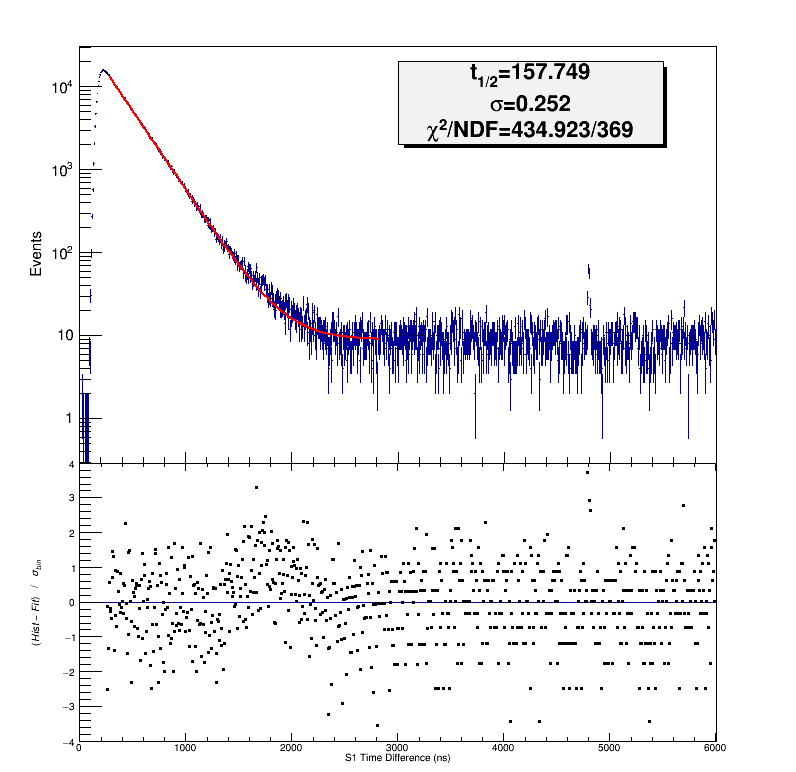

In [7]:
# Halflife Plot
    
c1 = ROOT.TCanvas('','', 800, 800 )
ROOT.gStyle.SetPadBorderMode(0)
ROOT.gStyle.SetFrameBorderMode(0)
small = 1e-5
ROOT.gStyle.SetOptStat(0)

p1a = ROOT.TPad("", "", 0.0, 0.4, 1.0, 1.0)
p1b = ROOT.TPad("", "", 0.0, 0.0, 1.0, 0.4)
p1a.Draw()
p1b.Draw()

p1ah = p1a.cd()
p1ah.SetLogy()
ROOT.gPad.SetBottomMargin(1e-5);
dtH.GetXaxis().SetTitle("S1 Time Difference (ns)")
dtH.GetXaxis().CenterTitle()
dtH.GetYaxis().SetTitle("Events")
dtH.GetYaxis().CenterTitle()
dtH.GetXaxis().SetRangeUser(0,6000)
dtH.Sumw2()
dtH.SetStats(False)
dtH.Draw()
dtH.Fit("fitFun","","",277.7,2825)
fit = dtH.GetFunction("fitFun")
chi2 = fit.GetChisquare()
ndf = fit.GetNDF()
p0 = fit.GetParameter(0)
e0 = fit.GetParError(0)
p1 = fit.GetParameter(1)
e1 = fit.GetParError(1)
p2 = fit.GetParameter(2)

pt = ROOT.TPaveText(3000,2000,5500,20000)
pt.AddText("t_{1/2}=%1.3f"%p1)
pt.AddText("#sigma=%1.3f"%e1)
pt.AddText("#chi^{2}/NDF=%1.3f/%i"%(chi2,ndf))
pt.Draw()

residuals = []
for i in range(dtH.GetNbinsX()):
    binCenter = dtH.GetBinCenter(i)
    res = (dtH.GetBinContent(i)-fitFun.Eval(binCenter))
    binError = dtH.GetBinError(i)
    residuals.append([binCenter,res,binError])
residuals = np.array(residuals)


resPlot = ROOT.TGraphErrors(len(residuals))
for i, res in enumerate(residuals):
    resPlot.SetPoint(i,res[0],res[1]/res[2])

p1bh = p1b.cd()
ROOT.gPad.SetTopMargin(small);
ROOT.gPad.SetTickx();
resPlot.SetLineColor(1)
resPlot.SetMarkerStyle(7)
resPlot.SetMarkerColor(1)
resPlot.Draw('AP')
resPlot.SetMaximum(4)
resPlot.SetMinimum(-4)
resPlot.SetTitle("")
resPlot.GetXaxis().SetTitle("S1 Time Difference (ns)")
resPlot.GetXaxis().CenterTitle()
resPlot.GetXaxis().SetRangeUser(0,6000)
resPlot.GetYaxis().SetTitle('(Hist - Fit)\ /\ \sigma _{bin}')
resPlot.GetYaxis().CenterTitle()


c1.Print('f_halflife.png')
c1.Clear()
Image('f_halflife.png')